## Recomendation using Collaborative Filtering


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import warnings
import tensorflow as tf
from keras.layers import Input, Embedding, Flatten, Dot, Dense, Concatenate
from keras.models import Model

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving tourism_rating.csv to tourism_rating (6).csv


In [ ]:
tourism = pd.read_csv('tourism_rating (1) (1).csv')

In [ ]:
tourism.head()

,User_Id,Place_Id,Place_Ratings
0,1,179,3
1,1,344,2
2,1,5,5
3,1,373,3
4,1,101,4


In [ ]:
tourism.shape

(10000, 3)

In [ ]:
tourism.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   User_Id        10000 non-null  int64
 1   Place_Id       10000 non-null  int64
 2   Place_Ratings  10000 non-null  int64
dtypes: int64(3)
memory usage: 234.5 KB


## split data for training 80% and for test 20%

In [ ]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(tourism, test_size=0.2, random_state=42)

In [ ]:
train.head()

,User_Id,Place_Id,Place_Ratings
9254,278,262,3
1561,49,251,2
1670,52,52,2
6087,183,385,1
6669,200,258,5


In [ ]:
test.head()

,User_Id,Place_Id,Place_Ratings
6252,188,207,3
4684,142,268,2
1731,54,103,3
4742,144,119,3
4521,138,288,5


In [ ]:
tourism['Place_Ratings'] = tourism['Place_Ratings'].astype(int)

In [ ]:
tourism.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   User_Id        10000 non-null  int64
 1   Place_Id       10000 non-null  int64
 2   Place_Ratings  10000 non-null  int64
dtypes: int64(3)
memory usage: 234.5 KB


In [ ]:
n_users = len(tourism.User_Id.unique())
n_users

300

In [ ]:
n_tourisms = len(tourism.Place_Ratings.unique())
n_tourisms

5

In [ ]:
n_tourisms = len(tourism.Place_Id.unique())
n_tourisms

437

## Nural Net


In [ ]:
# creating book embedding path
tourism_input = Input(shape=[1], name="Tourism-Input")
tourism_embedding = Embedding(n_tourisms+1, 5, name="Tourism-Embedding")(tourism_input)
tourism_vec = Flatten(name="Flatten-Tourism")(tourism_embedding)

# creating user embedding path
user_input = Input(shape=[1], name="User-Input")
user_embedding = Embedding(n_users+1, 5, name="User-Embedding")(user_input)
user_vec = Flatten(name="Flatten-Users")(user_embedding)

# concatenate features
conc = Concatenate()([tourism_vec, user_vec])

model2 = tf.keras.Sequential([
          Input(shape=[1], name="Tourism-Input"),
          Embedding(n_tourisms+1, 5, name="Tourism-Embedding"),
          #Flatten(name="Flatten-Tourism"),
          #Input(shape=[1], name="User-Input"),
          #Embedding(n_users+1, 5, name="User-Embedding"),
          Flatten(name="Flatten-Users"),
          #Concatenate()([tourism_vec, user_vec]),
          tf.keras.layers.Dense(128, activation='relu'),
          tf.keras.layers.Dense(64, activation='relu'),
          tf.keras.layers.Dense(1),
])

model2.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])


In [ ]:
# creating book embedding path
tourism_input = Input(shape=[1], name="Tourism-Input")
tourism_embedding = Embedding(n_tourisms+1, 5, name="Tourism-Embedding")(tourism_input)
tourism_vec = Flatten(name="Flatten-Tourism")(tourism_embedding)

# creating user embedding path
user_input = Input(shape=[1], name="User-Input")
user_embedding = Embedding(n_users+1, 5, name="User-Embedding")(user_input)
user_vec = Flatten(name="Flatten-Users")(user_embedding)

# concatenate features
conc = Concatenate()([tourism_vec, user_vec])

# add fully-connected-layers
fc1 = Dense(128, activation='relu')(conc)
fc2 = Dense(64, activation='relu')(fc1)
out = Dense(1)(fc2)

# Create model and compile it
model = Model([user_input, tourism_input], out)
model.compile('adam', 'mean_squared_error')


In [ ]:
model.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 Tourism-Input (InputLayer)  [(None, 1)]                  0         []                            
                                                                                                  
 User-Input (InputLayer)     [(None, 1)]                  0         []                            
                                                                                                  
 Tourism-Embedding (Embeddi  (None, 1, 5)                 2190      ['Tourism-Input[0][0]']       
 ng)                                                                                              
                                                                                                  
 User-Embedding (Embedding)  (None, 1, 5)                 1505      ['User-Input[0][0]']    

In [ ]:
import os
from keras.models import load_model

if os.path.exists('regression_model2.h5'):
    model2 = load_model('regression_model2.h5')
else:
    history = model.fit([train.User_Id, train.Place_Id], train.Place_Ratings, epochs=5, verbose=1)
    model2.save('regression_model2.h5')


Text(0, 0.5, 'Training Error')

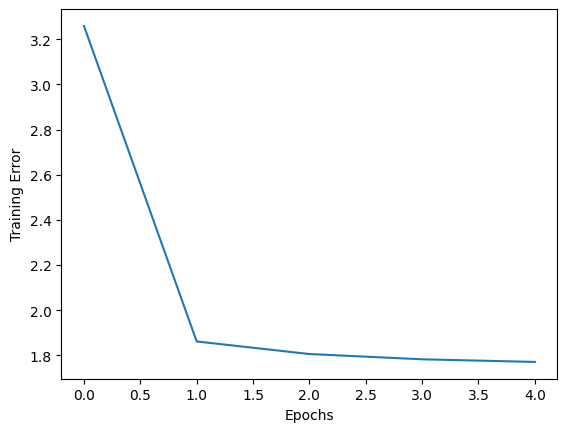

In [ ]:
plt.plot(history.history['loss'])
plt.xlabel("Epochs")
plt.ylabel("Training Error")

In [ ]:
model.evaluate([test.User_Id, test.Place_Id], test.Place_Ratings)

63/63 [==============================] - 0s 3ms/step - loss: 11.0783


11.078300476074219

In [ ]:
model.save('recommendation_rating_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
id_place = range(1,20)

In [ ]:
# Creating dataset for making recommendations for the first user
tourism_data = np.array(list(set(tourism.Place_Id)))
tourism_data[:10]


array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

In [ ]:
id_user = 3

In [ ]:
user = np.array([id_user for i in range(len(tourism_data))])
user[:10]

array([3, 3, 3, 3, 3, 3, 3, 3, 3, 3])

In [ ]:
predictions = model.predict([user, tourism_data])

predictions = np.array([a[0] for a in predictions])

recommended_tourism_ids = (-predictions).argsort()[:10]

recommended_tourism_ids

14/14 [==============================] - 0s 3ms/step


array([ 36, 283, 106, 139,  11, 374, 233, 295, 127, 286])

In [ ]:

# print predicted scores
predictions[recommended_tourism_ids]

array([-0.0039078 , -0.0044085 , -0.00444409, -0.00457275, -0.00491669,
       -0.00604326, -0.0068485 , -0.00700509, -0.00728511, -0.00731702],
      dtype=float32)